# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [1]:
#Imports&Settings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
from scipy.signal import butter
from scipy.signal import sosfilt
sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [8]:
#Data acquisition
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

n = 5 #seconds of data 
lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
N = lambda n : (int)(sampling_rate * n)  
lfp = lfp[:N(n)]
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 5.0 seconds of LFP, sampled at 1000.0 Hz


In [34]:
def applyFilter(lowf, highf, order):
    filter = butter(order, [lowf,highf], btype='band', output='sos', fs=sampling_rate)
    return sosfilt(filter, lfp)

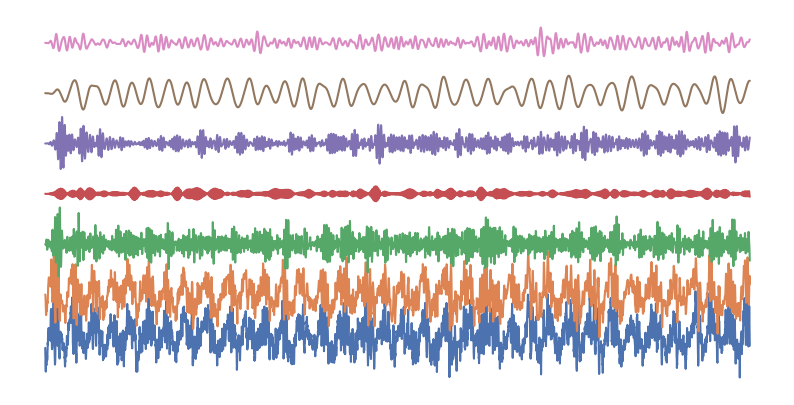

In [67]:
filter_order = 5
Flfp1 = applyFilter(1, 200, filter_order) #central frequency : 100, range +- 100
Flfp2 = applyFilter(50, 150, filter_order) # 100 +- 50
Flfp3 = applyFilter(90, 110, filter_order) # 100 +- 10
Flfp4 = applyFilter(40, 60, filter_order) # 50 +- 10
Flfp5 = applyFilter(4, 12, filter_order) # 8 +- 4 #Theta band
Flfp6 = applyFilter(15, 30, filter_order) # 22.5 +- 7.5 #beta band 

offset = 400
x = np.linspace(0,n,N)
plt.figure(figsize=(10,5))
plt.plot(x, lfp)
plt.plot(x, Flfp1 + offset*1)
plt.plot(x, Flfp2 + offset*2)
plt.plot(x, Flfp3 + offset*3)
plt.plot(x, Flfp4 + offset*4)
plt.plot(x, Flfp5 + offset*5)
plt.plot(x, Flfp6 + offset*6)
plt.xlabel('time (s)')
plt.axis('off')
plt.show()

The first 3 filters show different ranges with the same central frequency of 100Hz. The resulting plot show how the original signal gradually shifts into noise. The sharpest of these filters show low amplitude irregular noise.<br>
The fourth filter has a central frequency of 50. From the Fourier Transform of the lecture, we know that there is a high noise signal at this range. Comparing Filter 3 and 4, which have the same range, we can see this to be true since the noise signal of 50Hz has a clearly higher amplitude than that of 100Hz.<br>
Filter 5 shows the data filtered in the theta wave range ~(4-12)Hz. A clear periodic signal can be observed here, as expected.<br>
The last filter shows the Beta band, which is involved in motor planning and preparation of sensorimotor regions in the cerebral cortex. Also, here a clear wave signal can be observed, although it differs strongly from the theta range, by irregular periodicity and amplitude. This means that the signal is present but altered more strongly through noise than the theta rhythm. This makes sense since the Beta range is more strongly correlated to the cerebral cortex, while the data is taken from observations in the hippocampus, where the theta range is predominant.

210 µs ± 4.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
510 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
676 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
829 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
944 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


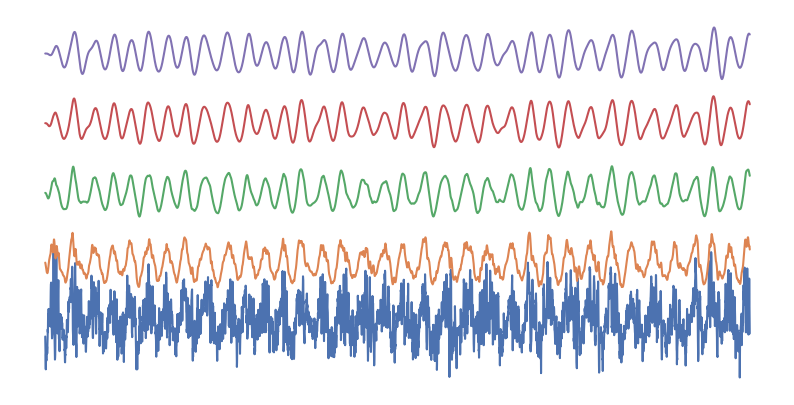

In [68]:
offset = 400
x = np.linspace(0,n,N)
plt.figure(figsize=(10,5))

for i in range(5):
    %timeit applyFilter(4, 12, i) # 8 +- 4 #Theta band
    Tlfp = applyFilter(4, 12, i)
    plt.plot(x, Tlfp + offset*i)
    
plt.xlabel('time (s)')
plt.axis('off')
plt.show()

The filter order has an approximately proportional relation between the 'clearness' of the signal and execution time.

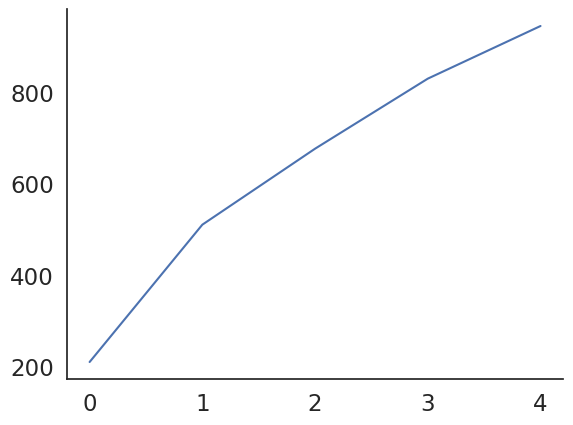

In [69]:
a = [210, 510, 676, 829, 944]
plt.plot(a)

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [6]:
#Can use same lfp data as in exercise 1.
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

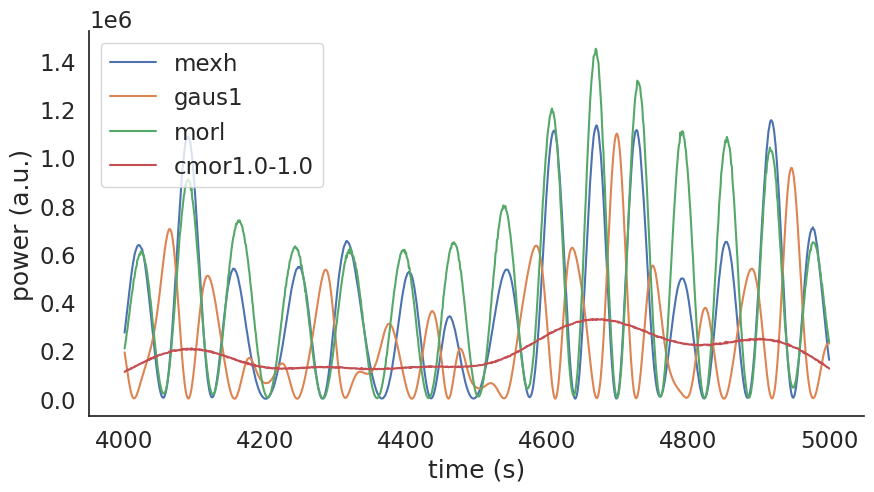

In [19]:
start = N(4)
end = N(5)

sig = lfp[start:end]
sig = sig - np.mean(sig) # get rid of 0 frequency component
frequencies =  np.linspace(6,10,50)/sampling_rate
wavelets = ['mexh', 'gaus1', 'morl', 'cmor1.0-1.0']
plt.figure(figsize=(10,5))

for wavelet in wavelets:
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                      sampling_period=1.0/sampling_rate)

    power = np.mean(abs(cwtmatr)**2,axis=0)

    plt.plot(np.linspace(start, end, len(power)), power, label=wavelet)
    plt.xlabel('time (s)')
    plt.ylabel('power (a.u.)')
plt.legend()
plt.show()

Mexican hat and real morlet have similar phase.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.